## Setup & Kaggle Configuration

In [1]:
# Import required libraries
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm.auto import tqdm
import glob
import zipfile
import shutil

print("Libraries imported successfully!")
print("Kaggle Workspace Version")

# Kaggle paths configuration
KAGGLE_INPUT = "/kaggle/input/dataset-sampah"  # Your uploaded dataset
KAGGLE_WORKING = "/kaggle/working"  # Output directory

# Expected waste classes
waste_classes = ['Organik', 'Anorganik', 'Lainnya']

# List folders in dataset root
available_datasets = [d for d in os.listdir(KAGGLE_INPUT) if os.path.isdir(os.path.join(KAGGLE_INPUT, d))]
print(f"Available directories in dataset root: {available_datasets}")

# Check if expected classes exist directly in root
if set(waste_classes).issubset(set(available_datasets)):
    DATASET_PATH = KAGGLE_INPUT  # Directly use the main folder
    print("✅ Waste dataset detected at root level!")
    print(f"Dataset path: {DATASET_PATH}")
    print(f"Classes found: {available_datasets}")
else:
    DATASET_PATH = None
    print("❌ Expected classes not found! Make sure structure is:")
    print("dataset-sampah/")
    print(" ├── Organik/")
    print(" ├── Anorganik/")
    print(" └── Lainnya/")

if DATASET_PATH is not None:
    # Output paths
    OUTPUT_PATH = f"{KAGGLE_WORKING}/detection_data"
    ANNOTATIONS_PATH = f"{OUTPUT_PATH}/annotations"
    IMAGES_PATH = f"{OUTPUT_PATH}/images"
    
    # Create directories
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    os.makedirs(ANNOTATIONS_PATH, exist_ok=True)
    os.makedirs(IMAGES_PATH, exist_ok=True)
    
    print(f"✅ Output will be saved to: {OUTPUT_PATH}")

Libraries imported successfully!
Kaggle Workspace Version
Available directories in dataset root: ['Anorganik', 'Lainnya', 'Organik']
✅ Waste dataset detected at root level!
Dataset path: /kaggle/input/dataset-sampah
Classes found: ['Anorganik', 'Lainnya', 'Organik']
✅ Output will be saved to: /kaggle/working/detection_data


## Dataset Analysis & Processing

In [2]:
def analyze_kaggle_dataset(dataset_path):
    """Analyze Kaggle dataset structure and image counts"""
    
    if not dataset_path:
        return {}
    
    analysis = {
        'classes': [],
        'total_images': 0,
        'class_counts': {},
        'sample_dimensions': []
    }
    
    # Get all subdirectories (classes)
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    analysis['classes'] = classes
    
    print("Dataset Analysis:")
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        
        # Count images
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_path, ext)))
        
        count = len(image_files)
        analysis['class_counts'][class_name] = count
        analysis['total_images'] += count
        
        print(f"   {class_name}: {count} images")
        
        # Sample image dimensions (first 5 images)
        for img_path in image_files[:5]:
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    h, w = img.shape[:2]
                    analysis['sample_dimensions'].append((w, h))
            except:
                continue
    
    if analysis['sample_dimensions']:
        avg_width = np.mean([d[0] for d in analysis['sample_dimensions']])
        avg_height = np.mean([d[1] for d in analysis['sample_dimensions']])
        print(f"   Average dimensions: {avg_width:.0f} x {avg_height:.0f}")
    
    print(f"   Total images: {analysis['total_images']}")
    
    return analysis

# Analyze dataset
if DATASET_PATH:
    dataset_analysis = analyze_kaggle_dataset(DATASET_PATH)
else:
    dataset_analysis = {}

Dataset Analysis:
   Anorganik: 6000 images
   Lainnya: 6000 images
   Organik: 6000 images
   Average dimensions: 477 x 458
   Total images: 18000


## Kaggle-Optimized Auto-Annotation

In [3]:
def auto_generate_annotations_kaggle(dataset_path, output_path, max_images_per_class=6000):
    """
    Kaggle-optimized annotation generation with memory management
    """
    
    if not dataset_path:
        print("No dataset path provided")
        return [], []
    
    all_annotations = []
    processed_count = 0
    
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    print("Generating annotations for Kaggle workspace...")
    print(f"Processing classes: {classes}")
    print(f"Max images per class: {max_images_per_class}")
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        
        # Get all images
        image_files = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
            image_files.extend(glob.glob(os.path.join(class_path, ext)))
        
        # Limit for memory management
        if len(image_files) > max_images_per_class:
            image_files = image_files[:max_images_per_class]
            print(f"   {class_name}: Using {max_images_per_class} out of {len(glob.glob(os.path.join(class_path, '*.*')))} images")
        
        print(f"   Processing {class_name}: {len(image_files)} images")
        
        for img_path in tqdm(image_files, desc=f"Processing {class_name}"):
            try:
                # Load image efficiently
                img = cv2.imread(img_path)
                if img is None:
                    continue
                    
                height, width = img.shape[:2]
                
                # Smart bounding box generation
                # Coverage: 70-90% with random variations
                coverage = np.random.uniform(0.7, 0.9)
                
                box_width = int(width * coverage)
                box_height = int(height * coverage)
                
                # Center with small random offset
                center_x = width // 2
                center_y = height // 2
                
                max_offset = min(width, height) // 10  # 10% max offset
                offset_x = np.random.randint(-max_offset, max_offset)
                offset_y = np.random.randint(-max_offset, max_offset)
                
                x_min = max(0, center_x - box_width//2 + offset_x)
                y_min = max(0, center_y - box_height//2 + offset_y)
                x_max = min(width, x_min + box_width)
                y_max = min(height, y_min + box_height)
                
                # Ensure valid box
                if x_max <= x_min or y_max <= y_min:
                    continue
                
                # Create unique filename for Kaggle
                filename = f"{class_name}_{os.path.basename(img_path)}"
                output_img_path = os.path.join(output_path, "images", filename)
                
                # Copy image efficiently
                shutil.copy2(img_path, output_img_path)
                
                # Create annotation
                annotation = {
                    'filename': filename,
                    'width': width,
                    'height': height,
                    'source_class': class_name,
                    'objects': [{
                        'class': 'waste',
                        'x_min': x_min,
                        'y_min': y_min,
                        'x_max': x_max,
                        'y_max': y_max,
                        'confidence': 1.0
                    }]
                }
                
                all_annotations.append(annotation)
                processed_count += 1
                
                # Memory management: Clear variables
                del img
                
            except Exception as e:
                print(f"   Error processing {img_path}: {str(e)}")
                continue
        
        print(f"   {class_name}: {len([a for a in all_annotations if a['source_class'] == class_name])} annotations created")
    
    print(f"Total annotations created: {len(all_annotations)}")
    return all_annotations

# Generate annotations
if DATASET_PATH:
    print("Starting Kaggle annotation process...")
    annotations = auto_generate_annotations_kaggle(DATASET_PATH, OUTPUT_PATH)
    print(f"Generated {len(annotations)} annotations for Kaggle training")
else:
    annotations = []
    print("Skipping annotation generation - no dataset found")

Starting Kaggle annotation process...
Generating annotations for Kaggle workspace...
Processing classes: ['Anorganik', 'Lainnya', 'Organik']
Max images per class: 6000
   Processing Anorganik: 6000 images


Processing Anorganik:   0%|          | 0/6000 [00:00<?, ?it/s]

   Anorganik: 6000 annotations created
   Processing Lainnya: 6000 images


Processing Lainnya:   0%|          | 0/6000 [00:00<?, ?it/s]

   Lainnya: 6000 annotations created
   Processing Organik: 6000 images


Processing Organik:   0%|          | 0/6000 [00:00<?, ?it/s]

[ WARN:0@161.418] global grfmt_png.cpp:695 read_chunk chunk data is too large
libpng warning: iCCP: known incorrect sRGB profile


   Organik: 6000 annotations created
Total annotations created: 18000
Generated 18000 annotations for Kaggle training


## Save & Package for Kaggle

In [4]:
def create_kaggle_output_package(annotations, output_path):
    """
    Create comprehensive output package for Kaggle
    """
    
    if not annotations:
        print("No annotations to package")
        return
    
    print("Creating Kaggle output package...")
    
    # 1. Save main annotations
    json_path = os.path.join(output_path, "annotations", "waste_annotations.json")
    with open(json_path, 'w') as f:
        json.dump(annotations, f, indent=2)
    
    # 2. Create train/validation splits
    np.random.seed(42)
    indices = np.random.permutation(len(annotations))
    split_idx = int(0.8 * len(annotations))
    
    train_annotations = [annotations[i] for i in indices[:split_idx]]
    val_annotations = [annotations[i] for i in indices[split_idx:]]
    
    # Save splits
    train_path = os.path.join(output_path, "annotations", "train_annotations.json")
    val_path = os.path.join(output_path, "annotations", "val_annotations.json")
    
    with open(train_path, 'w') as f:
        json.dump(train_annotations, f, indent=2)
    with open(val_path, 'w') as f:
        json.dump(val_annotations, f, indent=2)
    
    # 3. Create comprehensive statistics
    stats = {
        'kaggle_version': True,
        'total_images': len(annotations),
        'total_objects': sum(len(ann['objects']) for ann in annotations),
        'detection_classes': ['waste'],
        'source_classes': list(set(ann['source_class'] for ann in annotations)),
        'train_split': len(train_annotations),
        'val_split': len(val_annotations),
        'split_ratio': 0.8,
        'annotation_strategy': 'auto_centered_bbox_kaggle_optimized',
        'average_image_size': {
            'width': np.mean([ann['width'] for ann in annotations]),
            'height': np.mean([ann['height'] for ann in annotations])
        },
        'next_steps': {
            'training': 'Use 06-train-detection-model-kaggle.ipynb',
            'model_output': 'Detection model in H5 format',
            'web_conversion': 'Convert H5 to TensorFlow.js for web deployment'
        }
    }
    
    stats_path = os.path.join(output_path, "annotations", "kaggle_stats.json")
    with open(stats_path, 'w') as f:
        json.dump(stats, f, indent=2)
    
    # 4. Create README for next steps
    readme_content = f"""# Waste Detection Training Data - Kaggle Generated

## Dataset Summary
- **Total Images**: {len(annotations)}
- **Training Split**: {len(train_annotations)} images  
- **Validation Split**: {len(val_annotations)} images
- **Detection Class**: waste (single class)
- **Source Classes**: {stats['source_classes']}

## Structure
```
detection_data/
├── annotations/
│   ├── train_annotations.json    # Training data
│   ├── val_annotations.json      # Validation data
│   ├── waste_annotations.json    # Complete dataset
│   └── kaggle_stats.json         # Dataset statistics
├── images/                       # All processed images
└── README.md                     # This file
```

## Next Steps
1. Run `06-train-detection-model-kaggle.ipynb` to train detection model
2. Model will be saved as `.h5` file
3. Convert to TensorFlow.js for web deployment
4. Integrate with your existing CNN-SVM models

## Integration with CNN-SVM
- Stage 1: This detection model finds waste objects
- Stage 2: Your CNN-SVM models classify as Organik/Anorganik/Lainnya
- Web deployment: Both models need conversion to TensorFlow.js

## Kaggle Outputs
All outputs are packaged in ZIP files for easy download and transfer.
"""
    
    readme_path = os.path.join(output_path, "README.md")
    with open(readme_path, 'w') as f:
        f.write(readme_content)
    
    print(f"Package created successfully!")
    print(f"   Training: {len(train_annotations)} samples")
    print(f"   Validation: {len(val_annotations)} samples")
    print(f"   Files saved to: {output_path}")
    
    return {
        'train_count': len(train_annotations),
        'val_count': len(val_annotations),
        'total_count': len(annotations),
        'output_path': output_path
    }

# Create package
if annotations:
    package_info = create_kaggle_output_package(annotations, OUTPUT_PATH)
else:
    package_info = None
    print("No package created - no annotations available")

Creating Kaggle output package...
Package created successfully!
   Training: 14400 samples
   Validation: 3600 samples
   Files saved to: /kaggle/working/detection_data


## Create ZIP Outputs for Kaggle

In [5]:
def create_zip_outputs(output_path):
    """
    Create ZIP files for easy Kaggle output management
    """
    
    if not os.path.exists(output_path):
        print("No output directory found")
        return
    
    zip_files = []
    
    print("Creating ZIP packages for Kaggle...")
    
    # 1. Annotations ZIP
    annotations_zip = f"{KAGGLE_WORKING}/waste_detection_annotations.zip"
    with zipfile.ZipFile(annotations_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
        annotations_dir = os.path.join(output_path, "annotations")
        for root, dirs, files in os.walk(annotations_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arc_path = os.path.relpath(file_path, output_path)
                zf.write(file_path, arc_path)
    
    zip_files.append(annotations_zip)
    print(f"   Annotations: {annotations_zip}")
    
    # 2. Sample Images ZIP (first 100 for verification)
    sample_zip = f"{KAGGLE_WORKING}/sample_detection_images.zip"
    with zipfile.ZipFile(sample_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
        images_dir = os.path.join(output_path, "images")
        image_files = os.listdir(images_dir)[:100]  # Limit for size
        
        for img_file in image_files:
            img_path = os.path.join(images_dir, img_file)
            zf.write(img_path, f"sample_images/{img_file}")
    
    zip_files.append(sample_zip)
    print(f"   Sample Images: {sample_zip}")
    
    # 3. Complete Package ZIP
    complete_zip = f"{KAGGLE_WORKING}/complete_detection_data.zip"
    with zipfile.ZipFile(complete_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
        for root, dirs, files in os.walk(output_path):
            for file in files:
                file_path = os.path.join(root, file)
                arc_path = os.path.relpath(file_path, OUTPUT_PATH)
                zf.write(file_path, arc_path)
    
    zip_files.append(complete_zip)
    print(f"   Complete Package: {complete_zip}")
    
    # Show file sizes
    print("ZIP File Sizes:")
    for zip_file in zip_files:
        if os.path.exists(zip_file):
            size_mb = os.path.getsize(zip_file) / (1024 * 1024)
            print(f"   {os.path.basename(zip_file)}: {size_mb:.1f} MB")
    
    return zip_files

# Create ZIP outputs
if package_info:
    zip_files = create_zip_outputs(OUTPUT_PATH)
    
    print("KAGGLE PACKAGE COMPLETE!")
    print("Generated ZIP Files:")
    for zip_file in zip_files:
        print(f"   {os.path.basename(zip_file)}")
    
    print("Next Steps:")
    print("   1. Download ZIP files from Kaggle output")
    print("   2. Run 06-train-detection-model-kaggle.ipynb")
    print("   3. Train MobileNetV3 detection model")
    print("   4. Export model for web integration")
else:
    print("No ZIP files created - package creation failed")

Creating ZIP packages for Kaggle...
   Annotations: /kaggle/working/waste_detection_annotations.zip
   Sample Images: /kaggle/working/sample_detection_images.zip
   Complete Package: /kaggle/working/complete_detection_data.zip
ZIP File Sizes:
   waste_detection_annotations.zip: 0.6 MB
   sample_detection_images.zip: 6.0 MB
   complete_detection_data.zip: 1259.8 MB
KAGGLE PACKAGE COMPLETE!
Generated ZIP Files:
   waste_detection_annotations.zip
   sample_detection_images.zip
   complete_detection_data.zip
Next Steps:
   1. Download ZIP files from Kaggle output
   2. Run 06-train-detection-model-kaggle.ipynb
   3. Train MobileNetV3 detection model
   4. Export model for web integration


## Sample Visualization

Showing sample annotations...


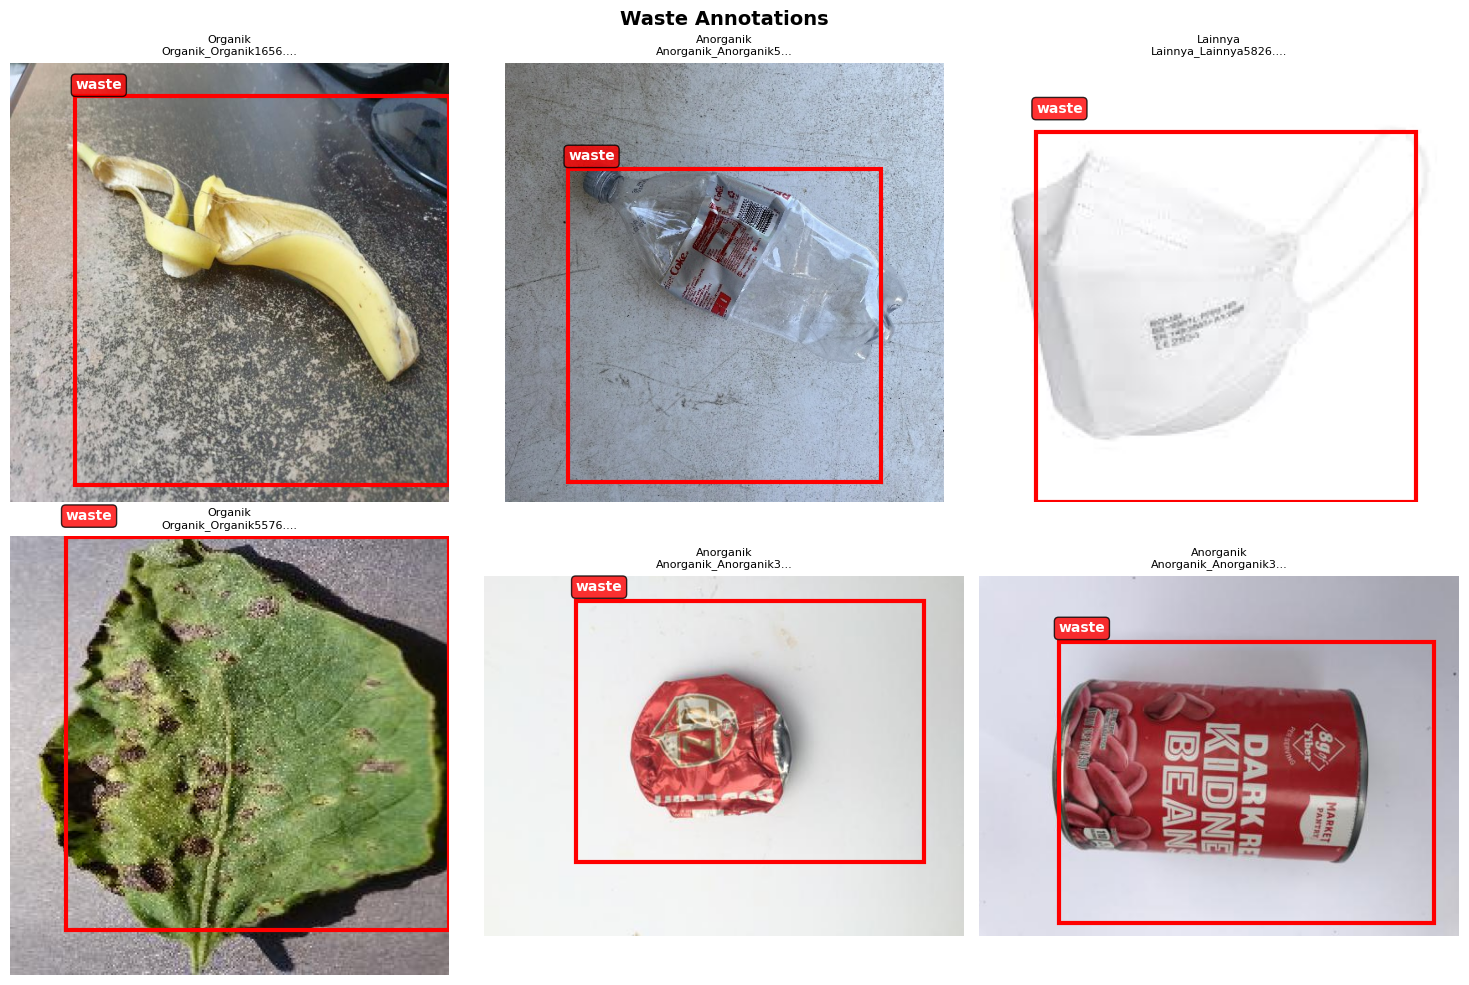

Sample visualization complete!
Red boxes show auto-detected waste objects
Ready for MobileNetV3 detection training


In [86]:
def visualize_kaggle_samples(annotations, images_path, num_samples=6):
    """
    Quick visualization for Kaggle verification
    """
    
    if not annotations:
        print("No annotations to visualize")
        return
    
    # Select samples
    sample_indices = np.random.choice(len(annotations), min(num_samples, len(annotations)), replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, idx in enumerate(sample_indices):
        if i >= len(axes):
            break
            
        annotation = annotations[idx]
        image_path = os.path.join(images_path, annotation['filename'])
        
        if not os.path.exists(image_path):
            continue
        
        # Load and display
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = axes[i]
        ax.imshow(img)
        
        # Draw bounding boxes
        for obj in annotation['objects']:
            x_min, y_min = obj['x_min'], obj['y_min']
            x_max, y_max = obj['x_max'], obj['y_max']
            
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=3, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            
            ax.text(x_min, y_min-10, "waste", 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.8),
                   fontsize=10, color='white', fontweight='bold')
        
        ax.set_title(f"{annotation['source_class']}\n{annotation['filename'][:20]}...", fontsize=8)
        ax.axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Waste Annotations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("Sample visualization complete!")
    print("Red boxes show auto-detected waste objects")
    print("Ready for MobileNetV3 detection training")

# Show samples
if annotations and os.path.exists(IMAGES_PATH):
    print("Showing sample annotations...")
    visualize_kaggle_samples(annotations, IMAGES_PATH)
else:
    print("No samples available for visualization")